# "Big Pandas" - Dask from the Inside
## Part 4 - Handling bigger data with Parquet
### PyData Amsterdam tutorial, 7 April 2017
### Stephen Simmons

In [253]:
# Complete set of Python 3.6 imports used for these examples

# Standard modules
import io
import logging
import lzma
import multiprocessing
import os
import ssl
import sys
import time
import urllib.request
import zipfile

# Third-party modules
import fastparquet      # Needs python-snappy and llvmlite
import graphviz         # To visualize Dask graphs 
import numpy as np
import pandas as pd
import psutil           # Memory stats
import dask
import dask.dataframe as dd
import bokeh.io         # For Dask profile graphs
import seaborn as sns   # For colormaps

# Support multiple lines of output in each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Don't wrap tables
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
pd.options.display.width = 300

# Show matplotlib and bokeh graphs inline in Jupyter notebook
%matplotlib inline
bokeh.io.output_notebook()

print(sys.version)
np.__version__, pd.__version__, dask.__version__

Loading BokehJS ...

3.6.0 |Continuum Analytics, Inc.| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


('1.11.3', '0.19.2', '0.14.1')

# Loading a Dask Dataframe from multiple large csv files

In [254]:
# Set DIR_NAME to where original .xz flight data is stored. 
DIR_NAME = '/home/stephen/do-not-backup/data/usa-flights-otp'

In [255]:
def load_otp_csv(start='2015-12', end='2016-03'):
    """
    Dask DataFrame with BTS On-Time Performance flight data loaded from
    multiple compressed monthly csv archives named 'flights-yyyy-mm.xz'.
    
    (Note pandas 0.19.2 drops the 'end' month. Reported as bug in GH#15886.)
    """
    paths = [ os.path.join(DIR_NAME, 'flights-%s.xz' % dt.strftime('%Y-%m'))
              for dt in pd.date_range(start, end, freq='M')]

    cols = [
        'FlightDate', 'Origin', 'Dest', 'OriginState', 'DestState',
        'Carrier', 'FlightNum', 'TailNum', 'CRSDepTime', 'CRSArrTime',
        'DepDelay', 'ArrDelay', 'Flights', 'Cancelled', 'Diverted',
        ]

    ddf = dd.read_csv(paths,
                     dialect="excel",
                     header=0,
                     compression='xz',
                     usecols=cols,
                     encoding='latin-1',  # Avoid unicode errors
                     blocksize=None,      # Can't split compressed csv into blocks
                     parse_dates=['FlightDate'],
                     dtype={ 'FlightNum': str, }, # Don't want this as a number
                     )
    return ddf

In [185]:
%%time
ddf = load_otp_csv(start='2015-12', end='2016-03')

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 23.5 ms


In [189]:
%%time
task = ddf[['Carrier','Flights','Cancelled']].groupby('Carrier').sum()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.41 ms


In [190]:
task

,Flights,Cancelled
npartitions=1,,
None,float64,float64
None,...,...


In [191]:
%%time
task.compute()

CPU times: user 13.7 s, sys: 1.18 s, total: 14.9 s
Wall time: 7.4 s


,Flights,Cancelled
Carrier,,
AA,223582.0,5001.0
AS,42063.0,311.0
B6,68137.0,1522.0
DL,208121.0,1472.0
EV,126036.0,4409.0
F9,21865.0,266.0
HA,18390.0,12.0
MQ,20993.0,805.0
NK,32072.0,894.0


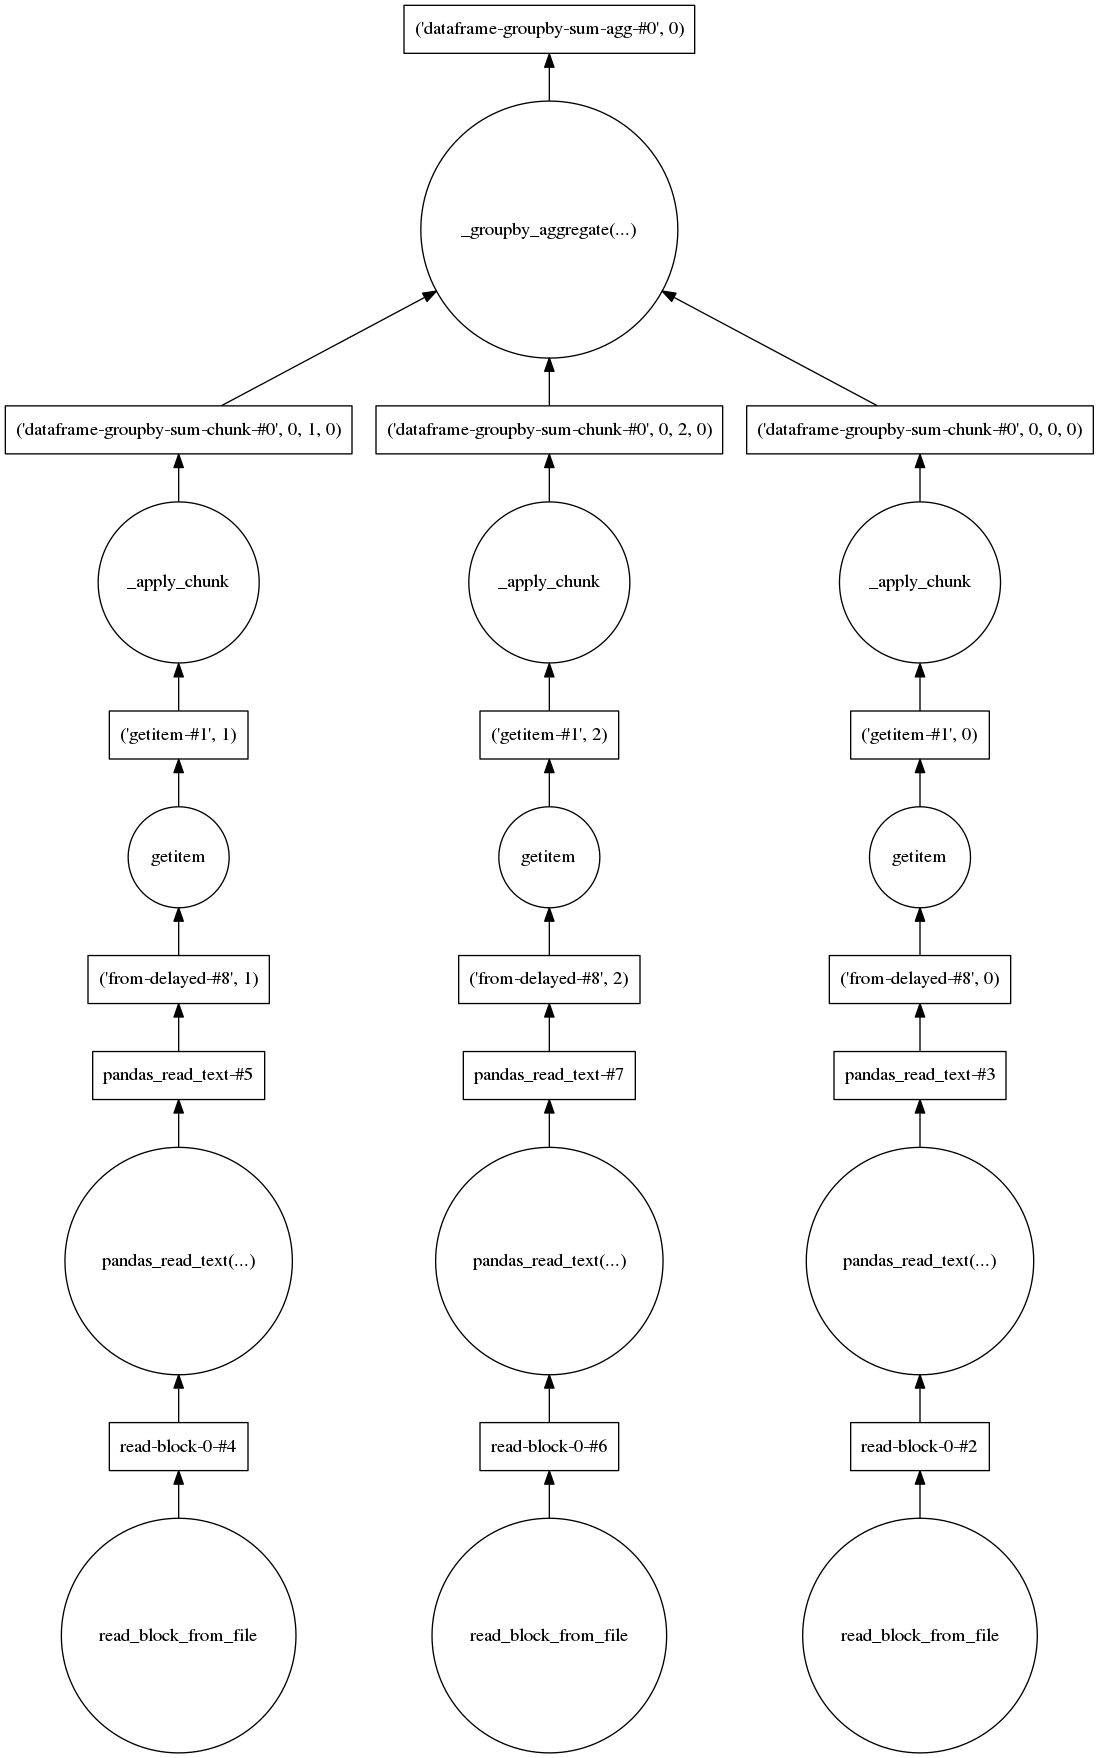

In [192]:
task.visualize()

# More complex example - more source files, with 'select' 

In [195]:
ddf = load_otp_csv(start='2016-01', end='2017-02')

In [196]:
task = ddf[ddf.FlightDate=='2016-01-24'][['Carrier','Flights','Cancelled']].groupby('Carrier').sum()

In [201]:
task

,Flights,Cancelled
npartitions=1,,
None,float64,float64
None,...,...


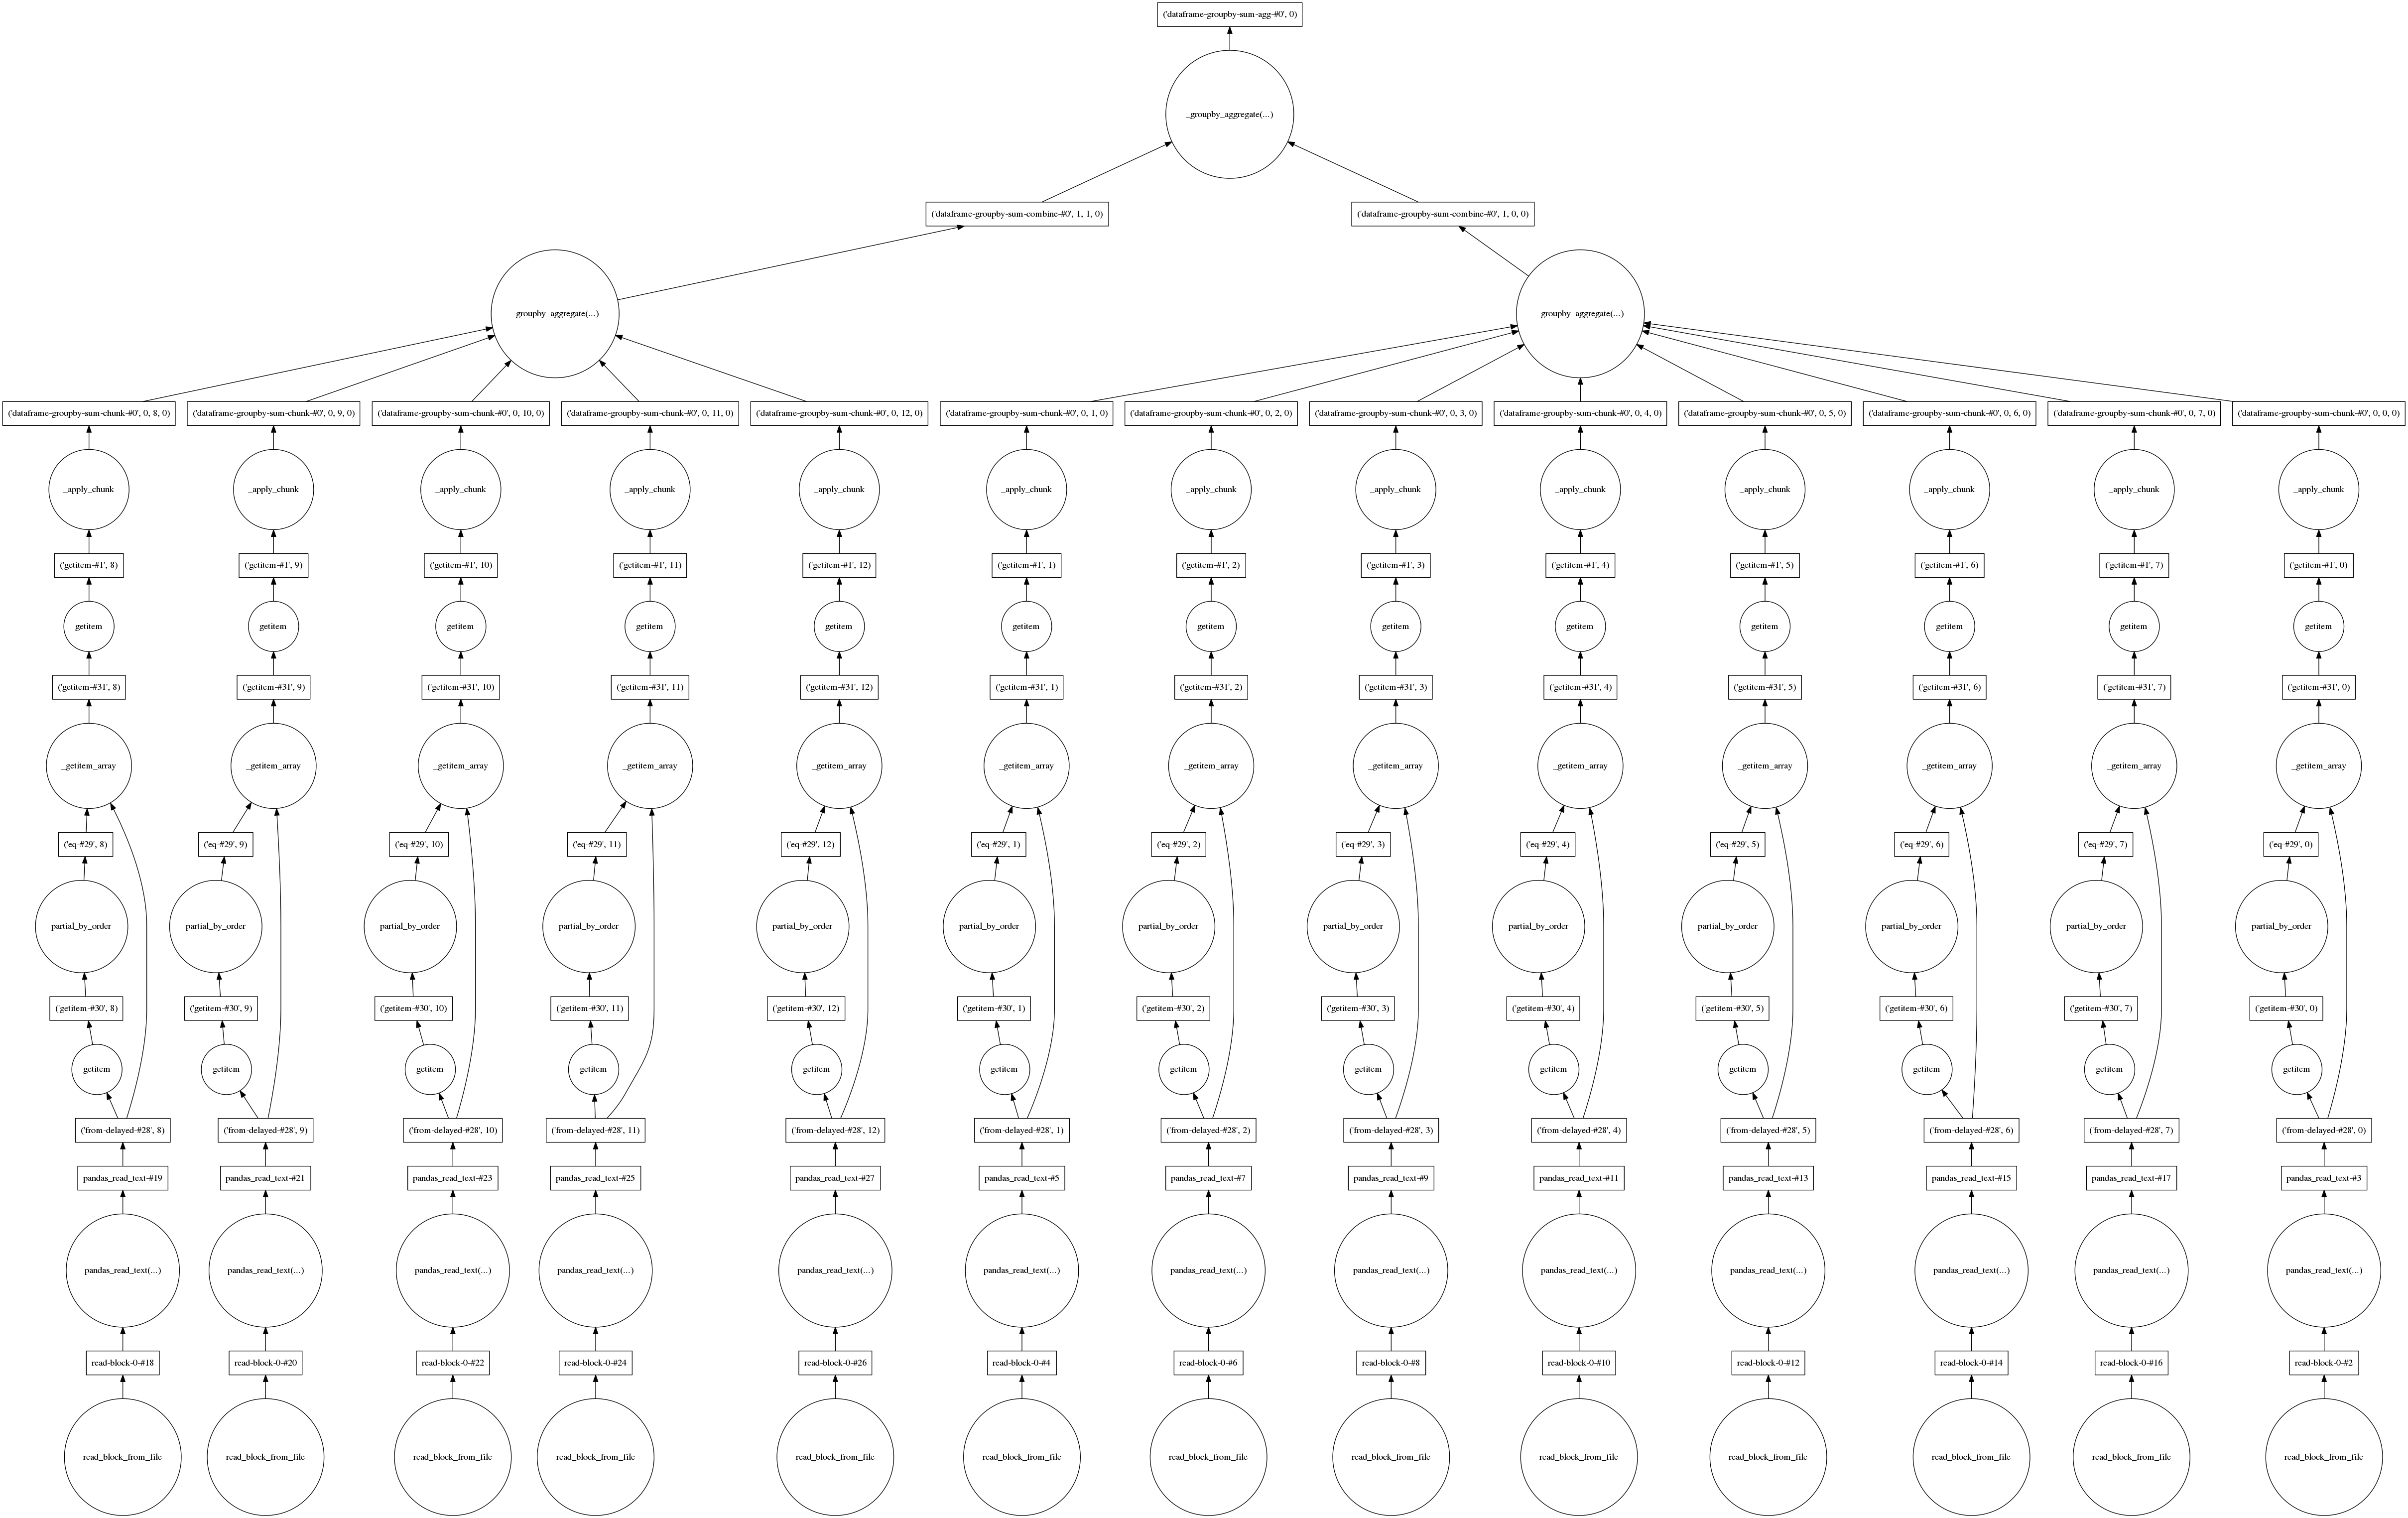

In [197]:
task.visualize()

In [202]:
ddf

,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginState,Dest,DestState,CRSDepTime,DepDelay,CRSArrTime,ArrDelay,Cancelled,Diverted,Flights
npartitions=13,,,,,,,,,,,,,,,
None,datetime64[ns],object,object,object,object,object,object,object,int64,float64,int64,float64,float64,float64,float64
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [203]:
ddf.npartitions
ddf.divisions

13

(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

We haven't given Dask any clues to optimize the computation.
It doesn't know a priori that the source data is organized by month.

In [204]:
ddf2 = ddf.set_index('FlightDate')

In [205]:
ddf2.npartitions
ddf2.divisions

13

(Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-04-01 00:00:00'),
 Timestamp('2016-05-01 00:00:00'),
 Timestamp('2016-06-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00'),
 Timestamp('2016-08-01 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2016-10-01 00:00:00'),
 Timestamp('2016-11-01 00:00:00'),
 Timestamp('2016-12-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-01-31 00:00:00'))

In [207]:
task2 = ddf2['2016-01-24'][['Carrier','Flights','Cancelled']].groupby('Carrier').sum()

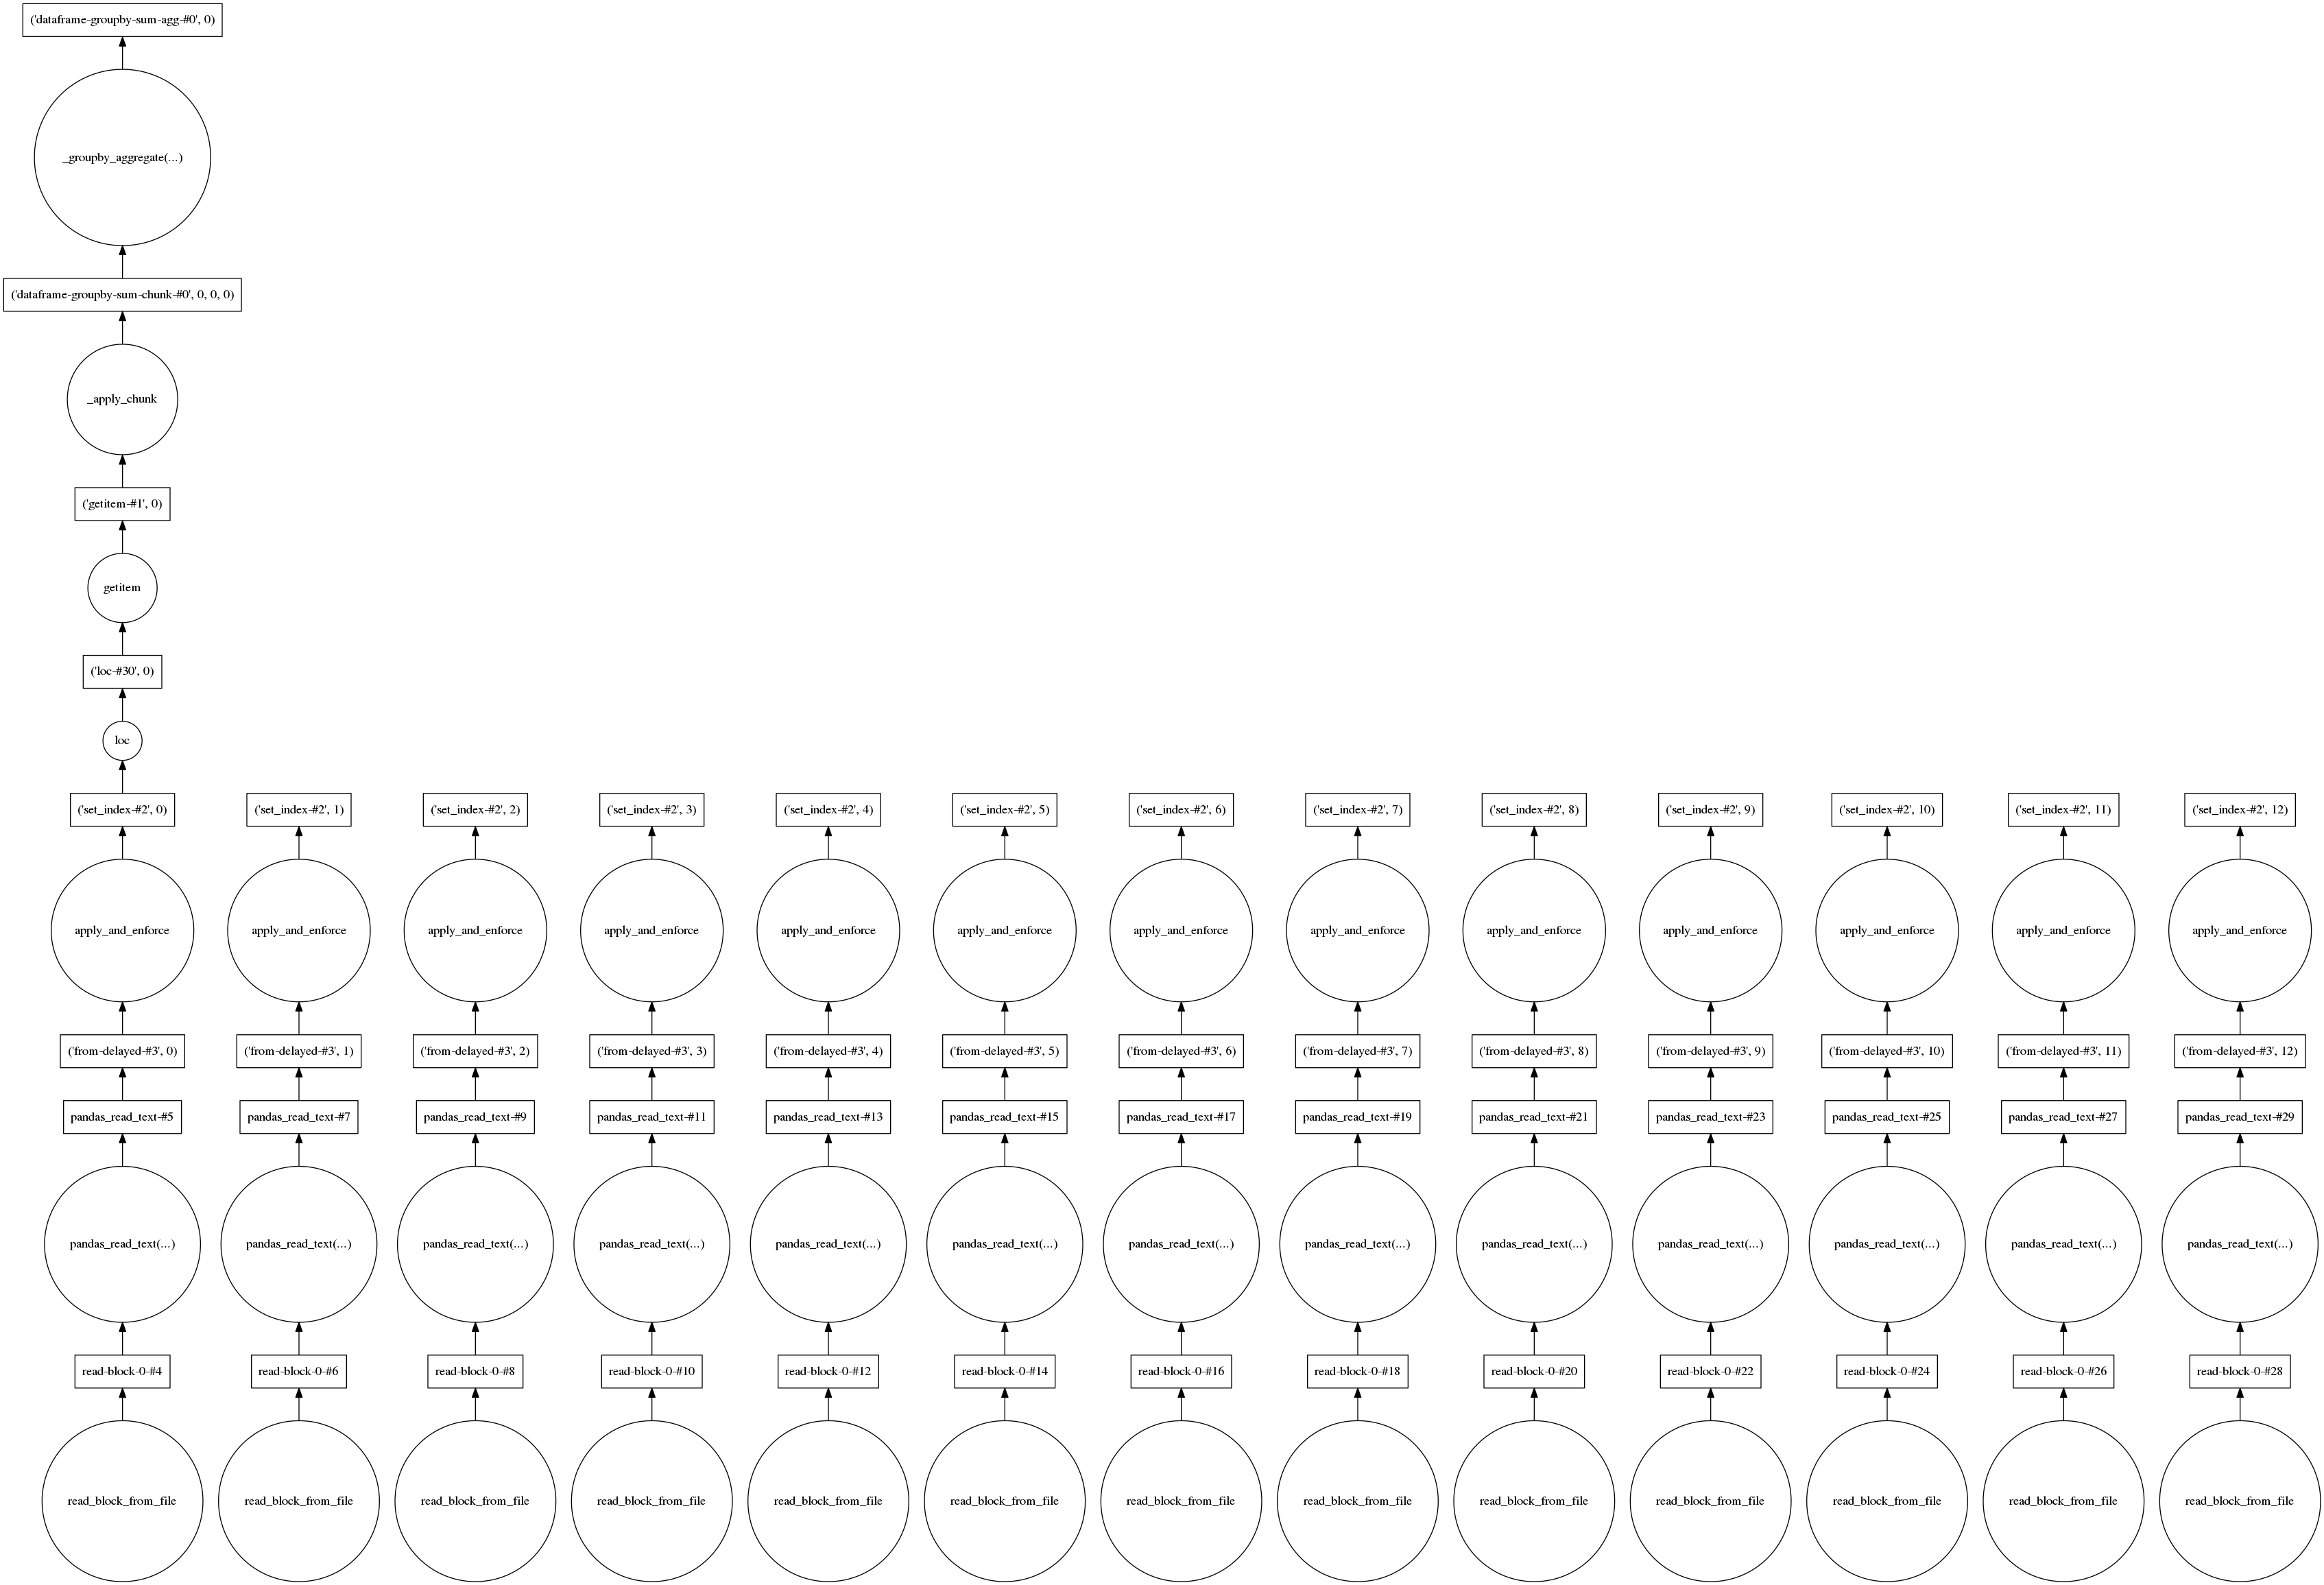

In [208]:
task2.visualize()

In [209]:
task2.compute()    # Oops!

KeyError: "Cannot get left slice bound for non-unique label: Timestamp('2016-01-24 00:00:00')"

Traceback
---------
  File "/home/stephen/miniconda3/envs/py36/lib/python3.6/site-packages/dask/async.py", line 266, in execute_task
    result = _execute_task(task, data)
  File "/home/stephen/miniconda3/envs/py36/lib/python3.6/site-packages/dask/async.py", line 247, in _execute_task
    return func(*args2)
  File "/home/stephen/miniconda3/envs/py36/lib/python3.6/site-packages/dask/dataframe/methods.py", line 20, in loc
    return df.loc[iindexer]
  File "/home/stephen/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py", line 1312, in __getitem__
    return self._getitem_axis(key, axis=0)
  File "/home/stephen/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py", line 1453, in _getitem_axis
    return self._get_slice_axis(key, axis=axis)
  File "/home/stephen/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py", line 1334, in _get_slice_axis
    slice_obj.step, kind=self.name)
  File "/home/stephen/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/tseries/index.py", line 1498, in slice_indexer
    return Index.slice_indexer(self, start, end, step, kind=kind)
  File "/home/stephen/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/indexes/base.py", line 2997, in slice_indexer
    kind=kind)
  File "/home/stephen/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/indexes/base.py", line 3176, in slice_locs
    start_slice = self.get_slice_bound(start, 'left', kind)
  File "/home/stephen/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/indexes/base.py", line 3136, in get_slice_bound
    "label: %r" % (side, original_label))


The problem here is Dask has assumed our partitioned data was completely sorted.

Remember slicing on labels can only return a single range if the column is monotonic.

We can make this happen by forcing a sort on each partition as it gets processed.

In [217]:
def sort_partition(df):
    return df.set_index(df.FlightDate).sort_index()

ddf3 = ddf.map_partitions(func=sort_partition)

In [221]:
ddf3
ddf3.divisions

,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginState,Dest,DestState,CRSDepTime,DepDelay,CRSArrTime,ArrDelay,Cancelled,Diverted,Flights
npartitions=13,,,,,,,,,,,,,,,
None,datetime64[ns],object,object,object,object,object,object,object,int64,float64,int64,float64,float64,float64,float64
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

In [219]:
task3 = ddf3['2016-01-24'][['Carrier','Flights','Cancelled']].groupby('Carrier').sum()

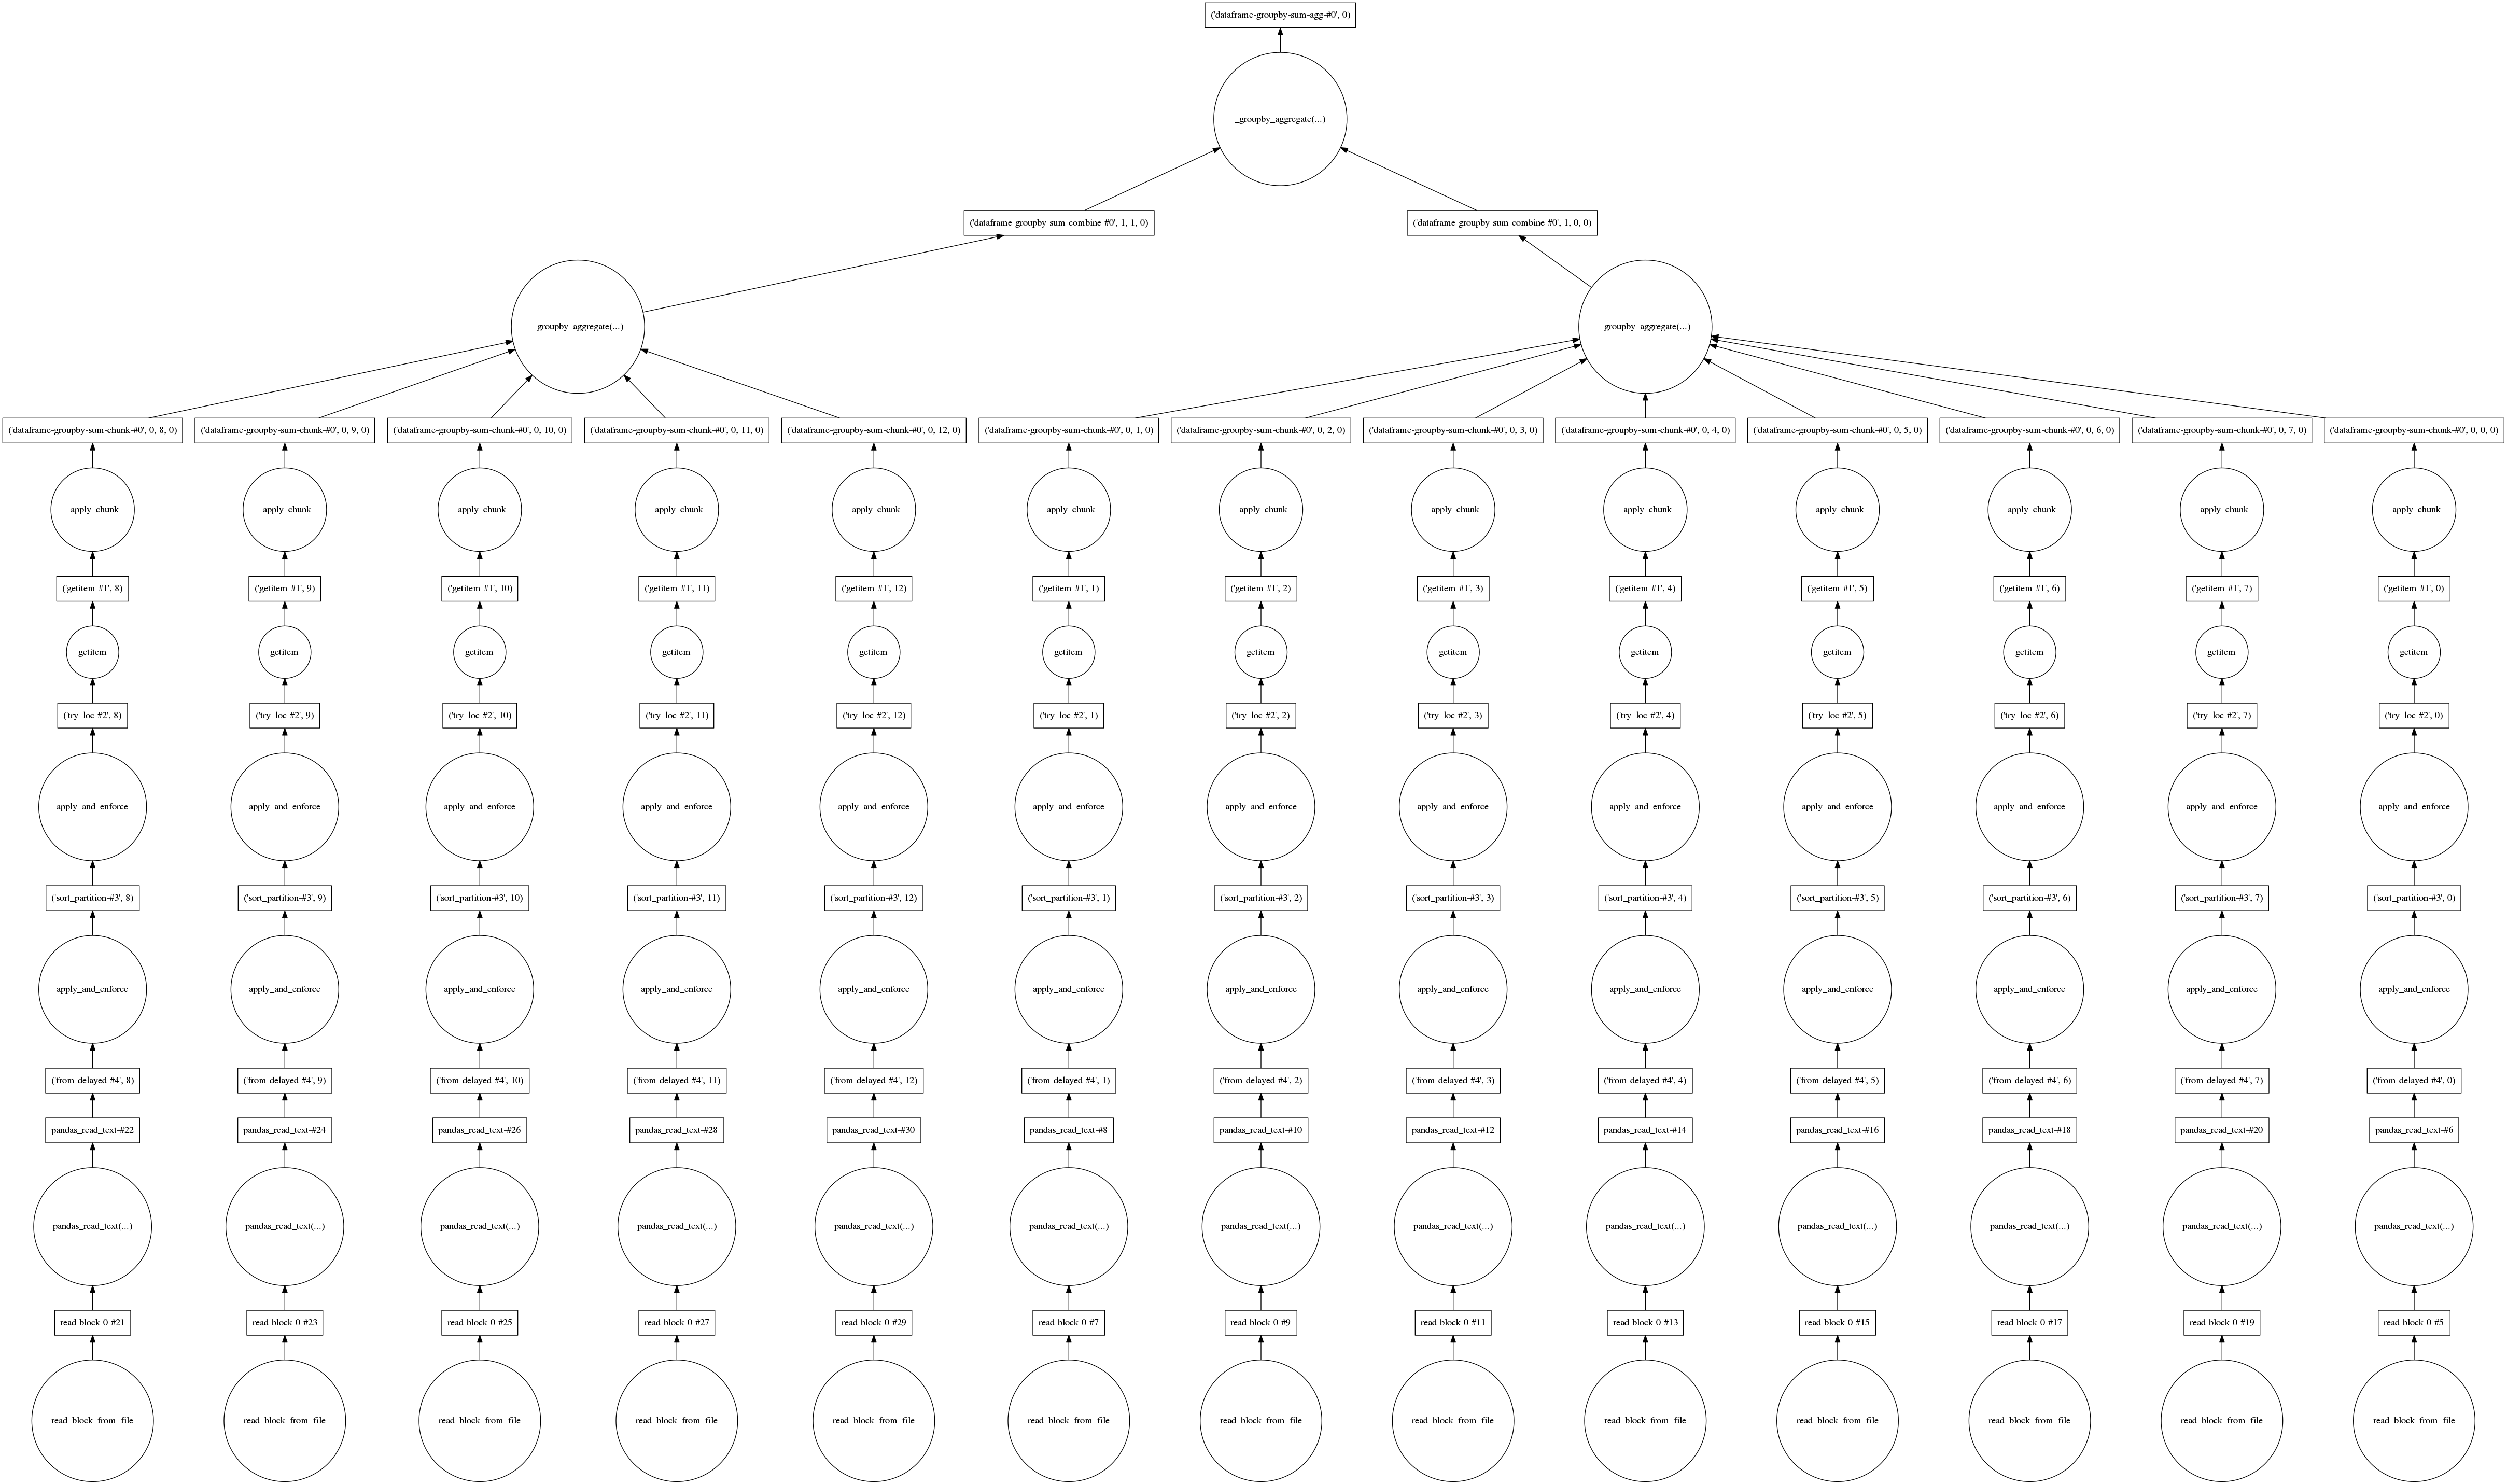

In [220]:
task3.visualize()

Here, even though we sort the partitions, the Dask graph is having to process everything.
We can help the graph optimizer by telling the top-level graph the Dask DataFrame's 
partitions are split on FlightDate.

In [231]:
ddf4 = ddf3.set_index('FlightDate')
ddf4
ddf4.divisions

,Carrier,TailNum,FlightNum,Origin,OriginState,Dest,DestState,CRSDepTime,DepDelay,CRSArrTime,ArrDelay,Cancelled,Diverted,Flights
npartitions=13,,,,,,,,,,,,,,
2016-01-01,object,object,object,object,object,object,object,int64,float64,int64,float64,float64,float64,float64
2016-02-01,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-31,...,...,...,...,...,...,...,...,...,...,...,...,...,...


(Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-04-01 00:00:00'),
 Timestamp('2016-05-01 00:00:00'),
 Timestamp('2016-06-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00'),
 Timestamp('2016-08-01 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2016-10-01 00:00:00'),
 Timestamp('2016-11-01 00:00:00'),
 Timestamp('2016-12-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-01-31 00:00:00'))

Now the dependency graph looks very different .... the evaluator can jump directly 
to the correct monthly dataset.

,Flights,Cancelled
npartitions=1,,
None,float64,float64
None,...,...


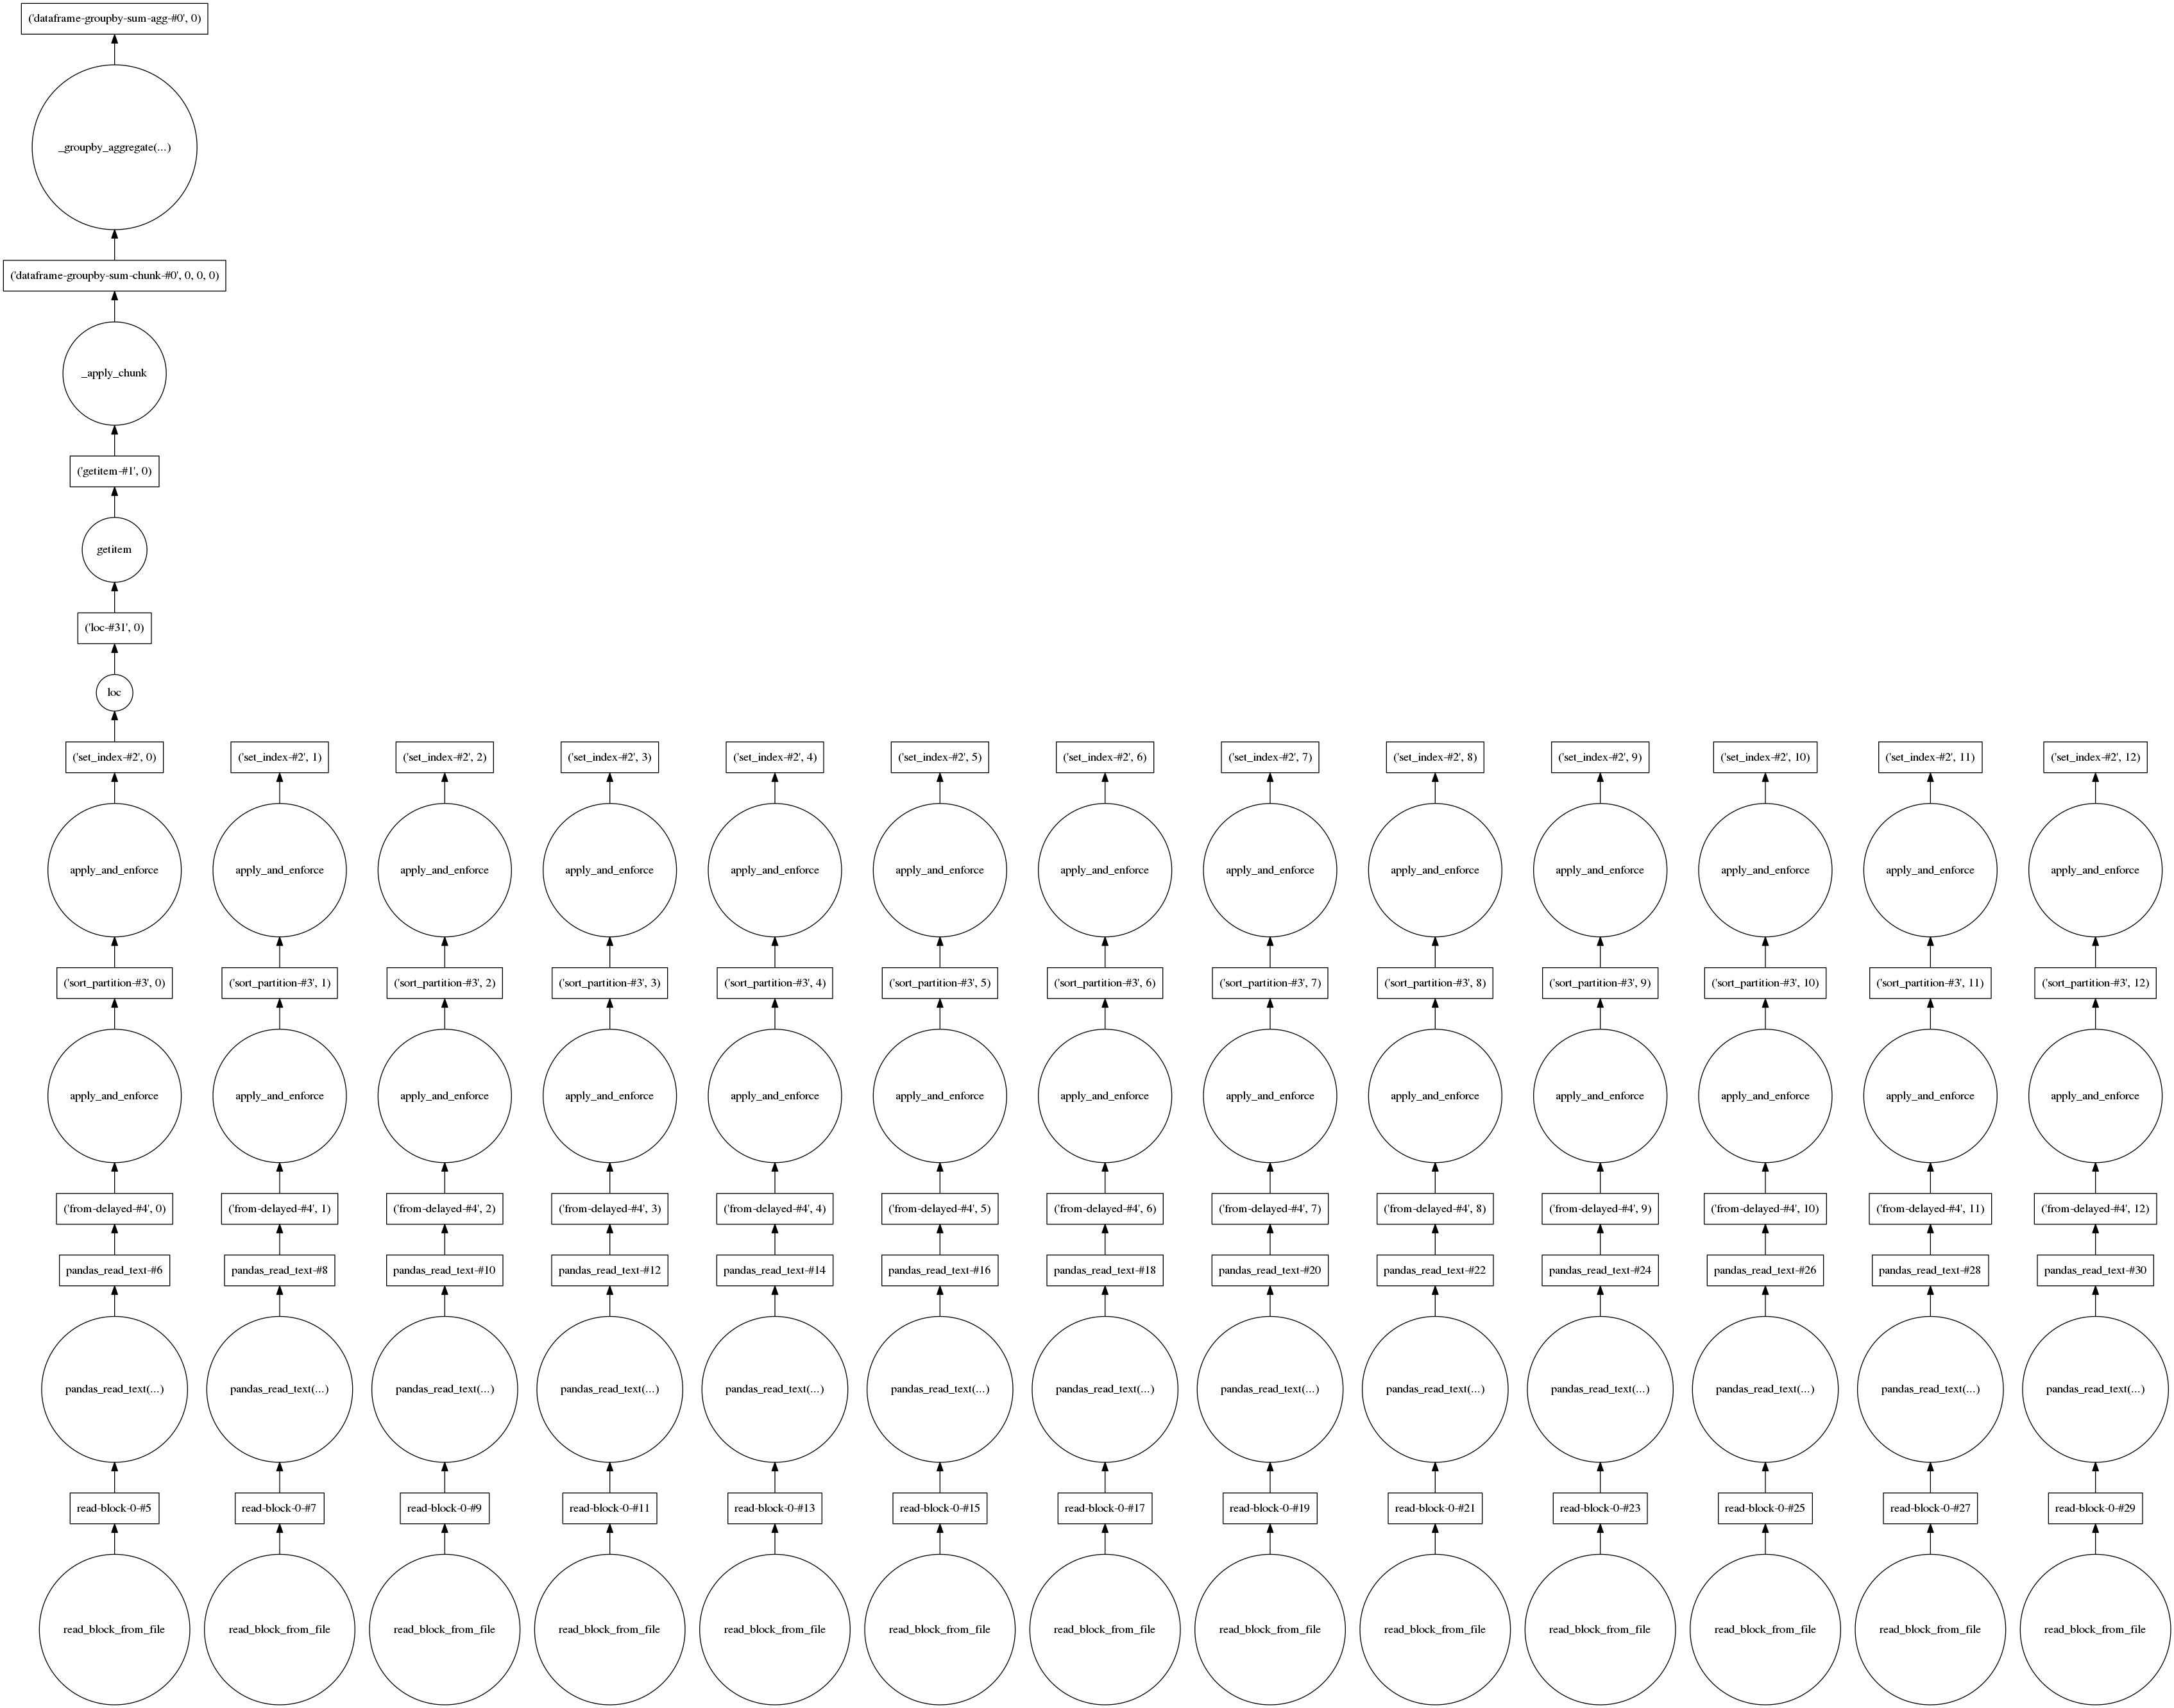

In [232]:
task4 = ddf4['2016-01-24'][['Carrier','Flights','Cancelled']].groupby('Carrier').sum()
task4
task4.visualize()

In [233]:
task4.compute()

,Flights,Cancelled
Carrier,,
AA,2423.0,620.0
AS,464.0,19.0
B6,739.0,247.0
DL,2325.0,272.0
EV,1290.0,262.0
F9,226.0,18.0
HA,201.0,0.0
NK,355.0,46.0
OO,1540.0,39.0


# Parquet - a faster storage format than csv

In [237]:
fastparquet.compression.compressions

{'GZIP': <function fastparquet.compression.gzip_compress_v3>,
 'SNAPPY': <function _snappy.compress>,
 'UNCOMPRESSED': <function fastparquet.compression.<lambda>>}

In [238]:
ddf4.to_parquet('flights.parq', compression='SNAPPY')

What does this data look like....

In [239]:
import fastparquet
pf = fastparquet.ParquetFile('flights.parq')

In [242]:
pf.columns

['FlightDate',
 'Carrier',
 'TailNum',
 'FlightNum',
 'Origin',
 'OriginState',
 'Dest',
 'DestState',
 'CRSDepTime',
 'DepDelay',
 'CRSArrTime',
 'ArrDelay',
 'Cancelled',
 'Diverted',
 'Flights']

In [245]:
pf.dtypes

{'ArrDelay': dtype('float64'),
 'CRSArrTime': dtype('int64'),
 'CRSDepTime': dtype('int64'),
 'Cancelled': dtype('float64'),
 'Carrier': dtype('O'),
 'DepDelay': dtype('float64'),
 'Dest': dtype('O'),
 'DestState': dtype('O'),
 'Diverted': dtype('float64'),
 'FlightDate': dtype('<M8[ns]'),
 'FlightNum': dtype('O'),
 'Flights': dtype('float64'),
 'Origin': dtype('O'),
 'OriginState': dtype('O'),
 'TailNum': dtype('O')}

In [246]:
%%time
ddf = dd.read_parquet('flights.parq', columns=['Carrier','Flights','Cancelled'])
x = (ddf.loc['2016-01-18':'2016-01-28']
         .reset_index()
         .groupby(by=['Carrier','FlightDate'])
         .sum()
    )
y = x['Cancelled']/x['Flights']*100
out = y.compute()

CPU times: user 224 ms, sys: 20 ms, total: 244 ms
Wall time: 425 ms


In [248]:
out

Carrier  FlightDate
AA       2016-01-19     0.339992
         2016-01-20     0.160064
         2016-01-21     1.327606
         2016-01-22    30.712339
         2016-01-23    36.307838
         2016-01-24    25.588114
         2016-01-25     8.853119
         2016-01-26     0.680272
         2016-01-27     0.360144
         2016-01-28     0.585709
                         ...    
WN       2016-01-19     1.247166
         2016-01-20     1.388889
         2016-01-21     1.133787
         2016-01-22    14.436219
         2016-01-23    21.369961
         2016-01-24    17.904074
         2016-01-25     4.630682
         2016-01-26     1.394422
         2016-01-27     0.910643
         2016-01-28     0.597610
dtype: float64

In [249]:
(out.unstack('FlightDate')
 .style
 .set_precision(2)
 .background_gradient(cmap=sns.light_palette("red", as_cmap=True), 
                      high=0.4, low=0.2, axis=1)
)

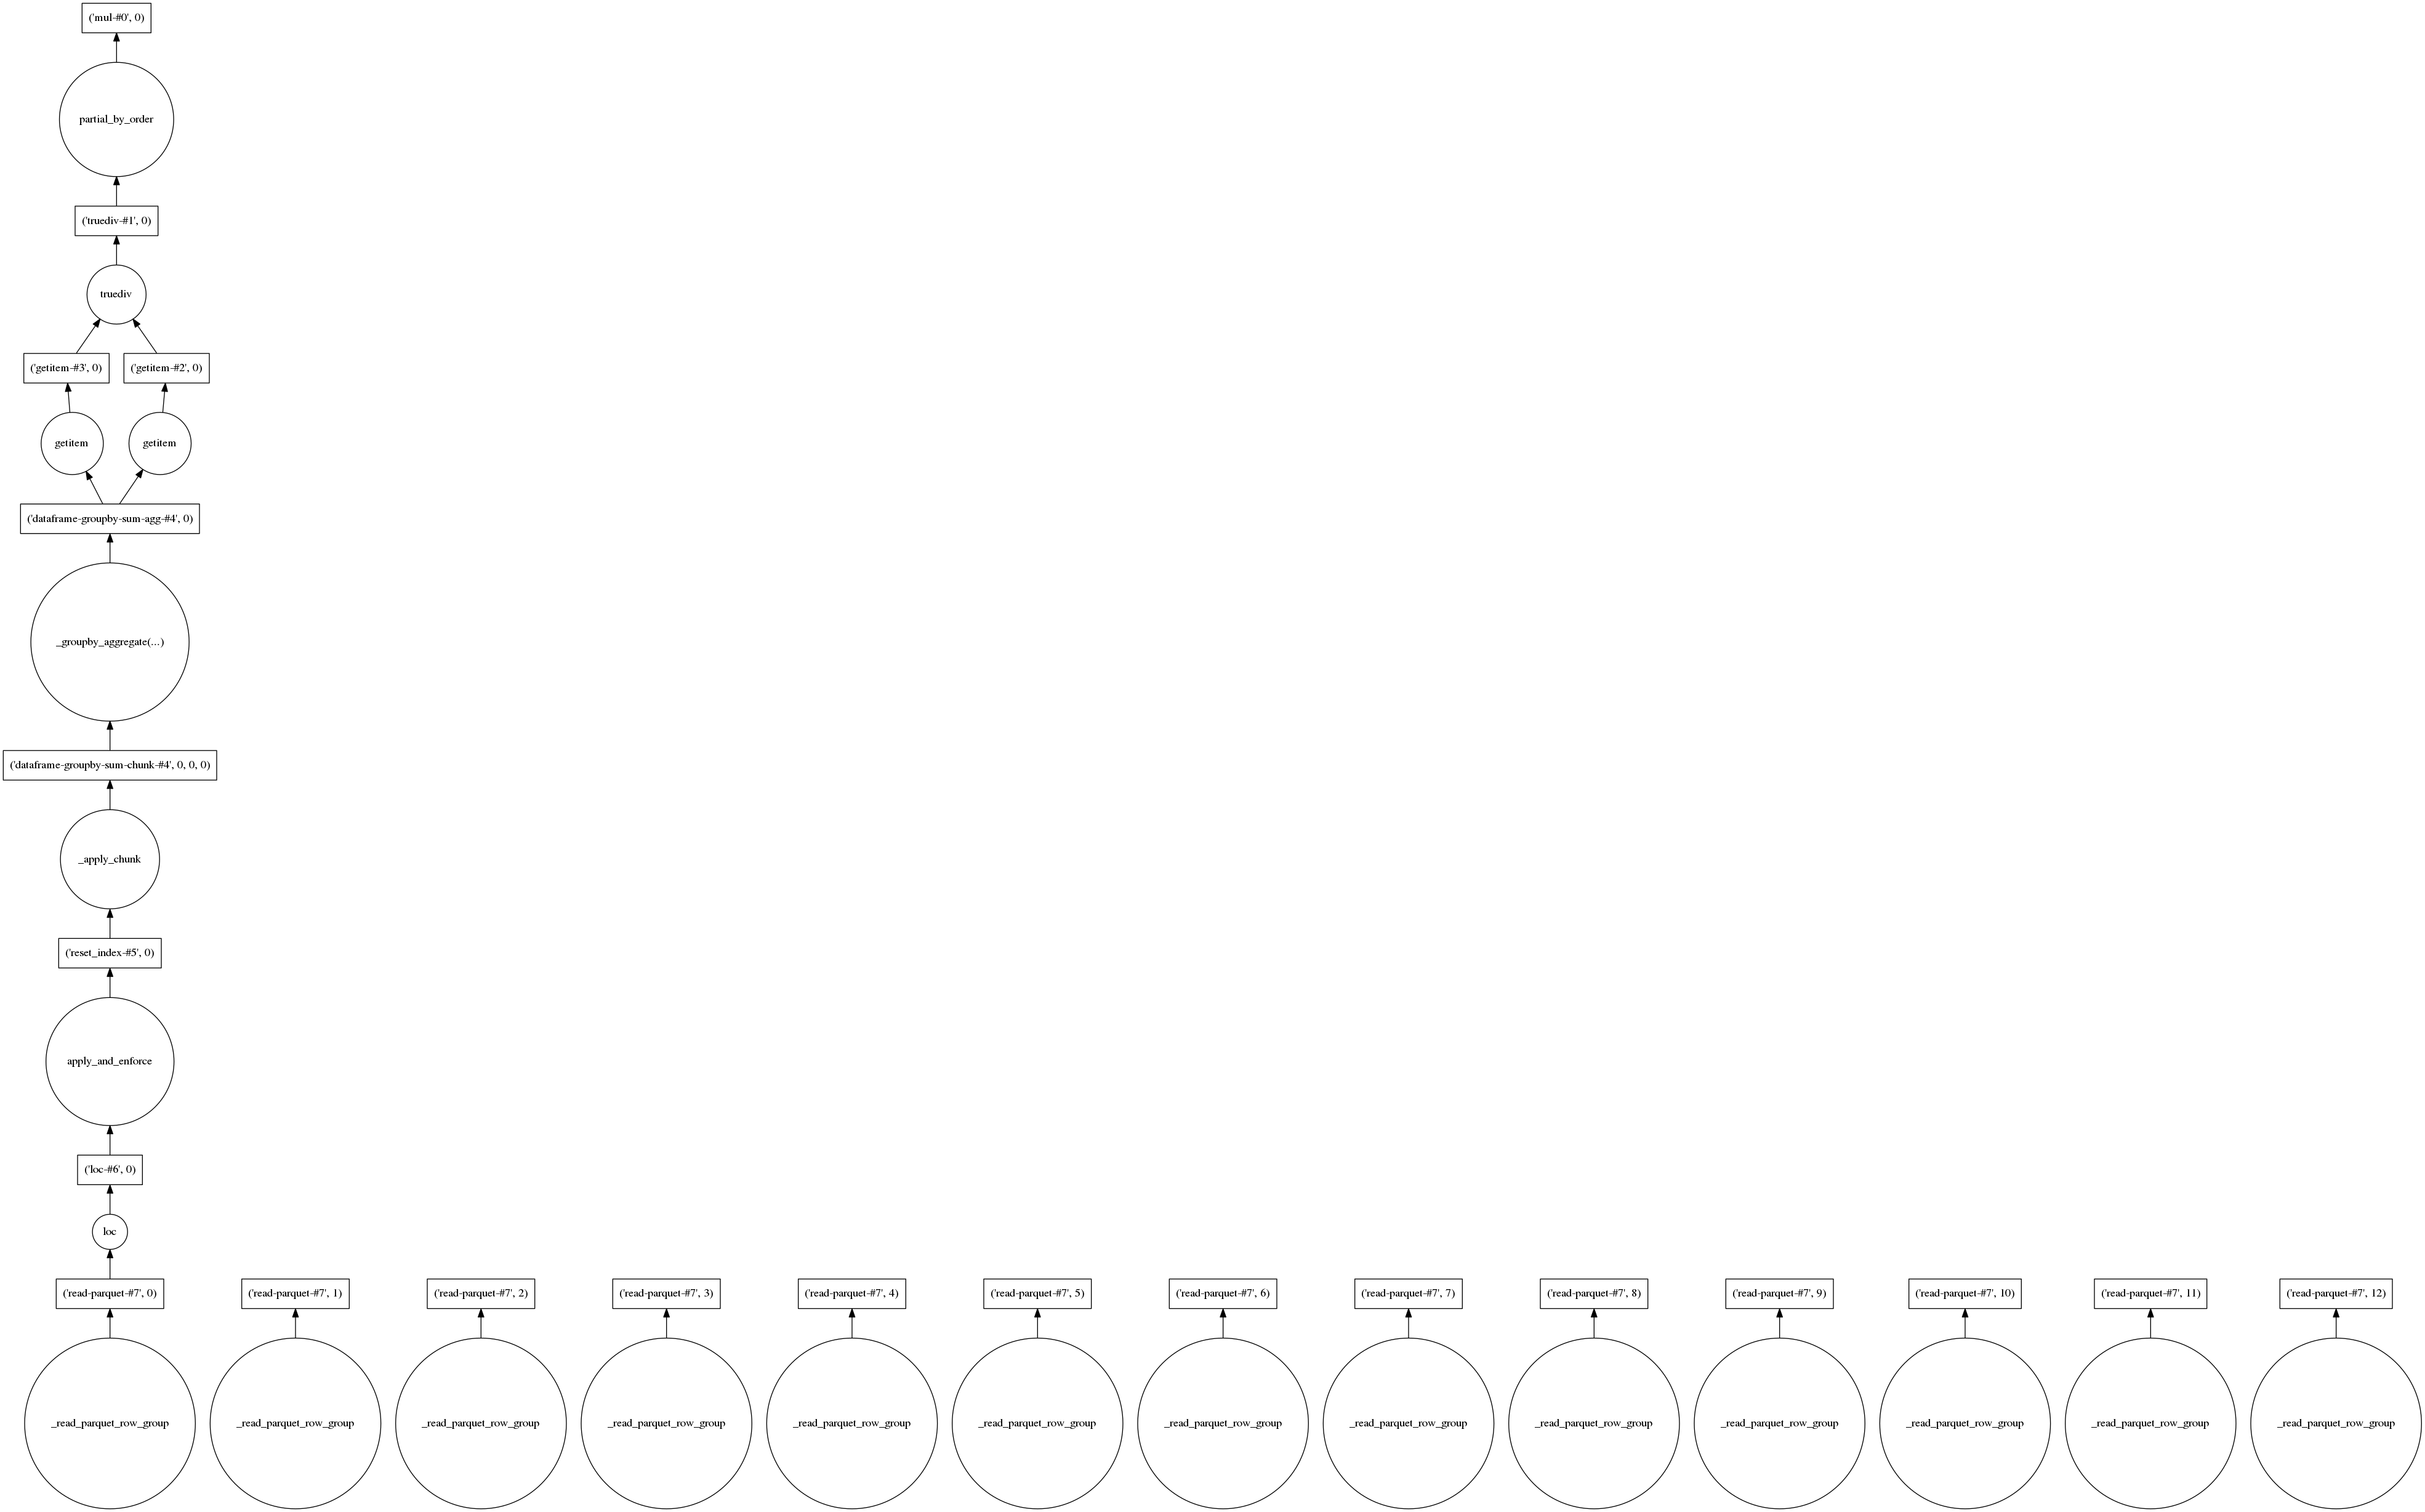

In [250]:
y.visualize()

# Visualizing Dask computations

In [257]:
import dask.diagnostics.profile as profile
from dask.diagnostics import ( ProgressBar, Profiler, 
                              ResourceProfiler, CacheProfiler )


In [290]:
ddf = dd.read_parquet('flights.parq')

sum_cols = ['Carrier', 'Flights', 'Cancelled', 'Diverted']
task = ddf[sum_cols].groupby('Carrier').sum()
task['CancelledPct'] = task['Cancelled'] / task['Flights'] * 100
task['DivertedPct'] = task['Diverted'] / task['Flights'] * 100

In [291]:
with ProgressBar():
    out = task.compute()

[########################################] | 100% Completed |  2.2s


In [292]:
print(out)

           Flights  Cancelled  Diverted  CancelledPct  DivertedPct
Carrier                                                           
AA        987627.0    11847.0    2421.0      1.199542     0.245133
AS        191991.0     1072.0     520.0      0.558360     0.270846
B6        307075.0     4322.0     774.0      1.407474     0.252056
DL        992559.0     4898.0    1923.0      0.493472     0.193742
EV        526027.0    13048.0    1723.0      2.480481     0.327550
F9        102881.0     1341.0     169.0      1.303448     0.164267
HA         83065.0      136.0      91.0      0.163727     0.109553
NK        150769.0     3070.0     218.0      2.036228     0.144592
OO        656079.0    10326.0    2181.0      1.573896     0.332429
UA        587470.0     5702.0    1522.0      0.970603     0.259077
VX         74903.0      806.0     272.0      1.076058     0.363136
WN       1407229.0    18179.0    3324.0      1.291830     0.236209


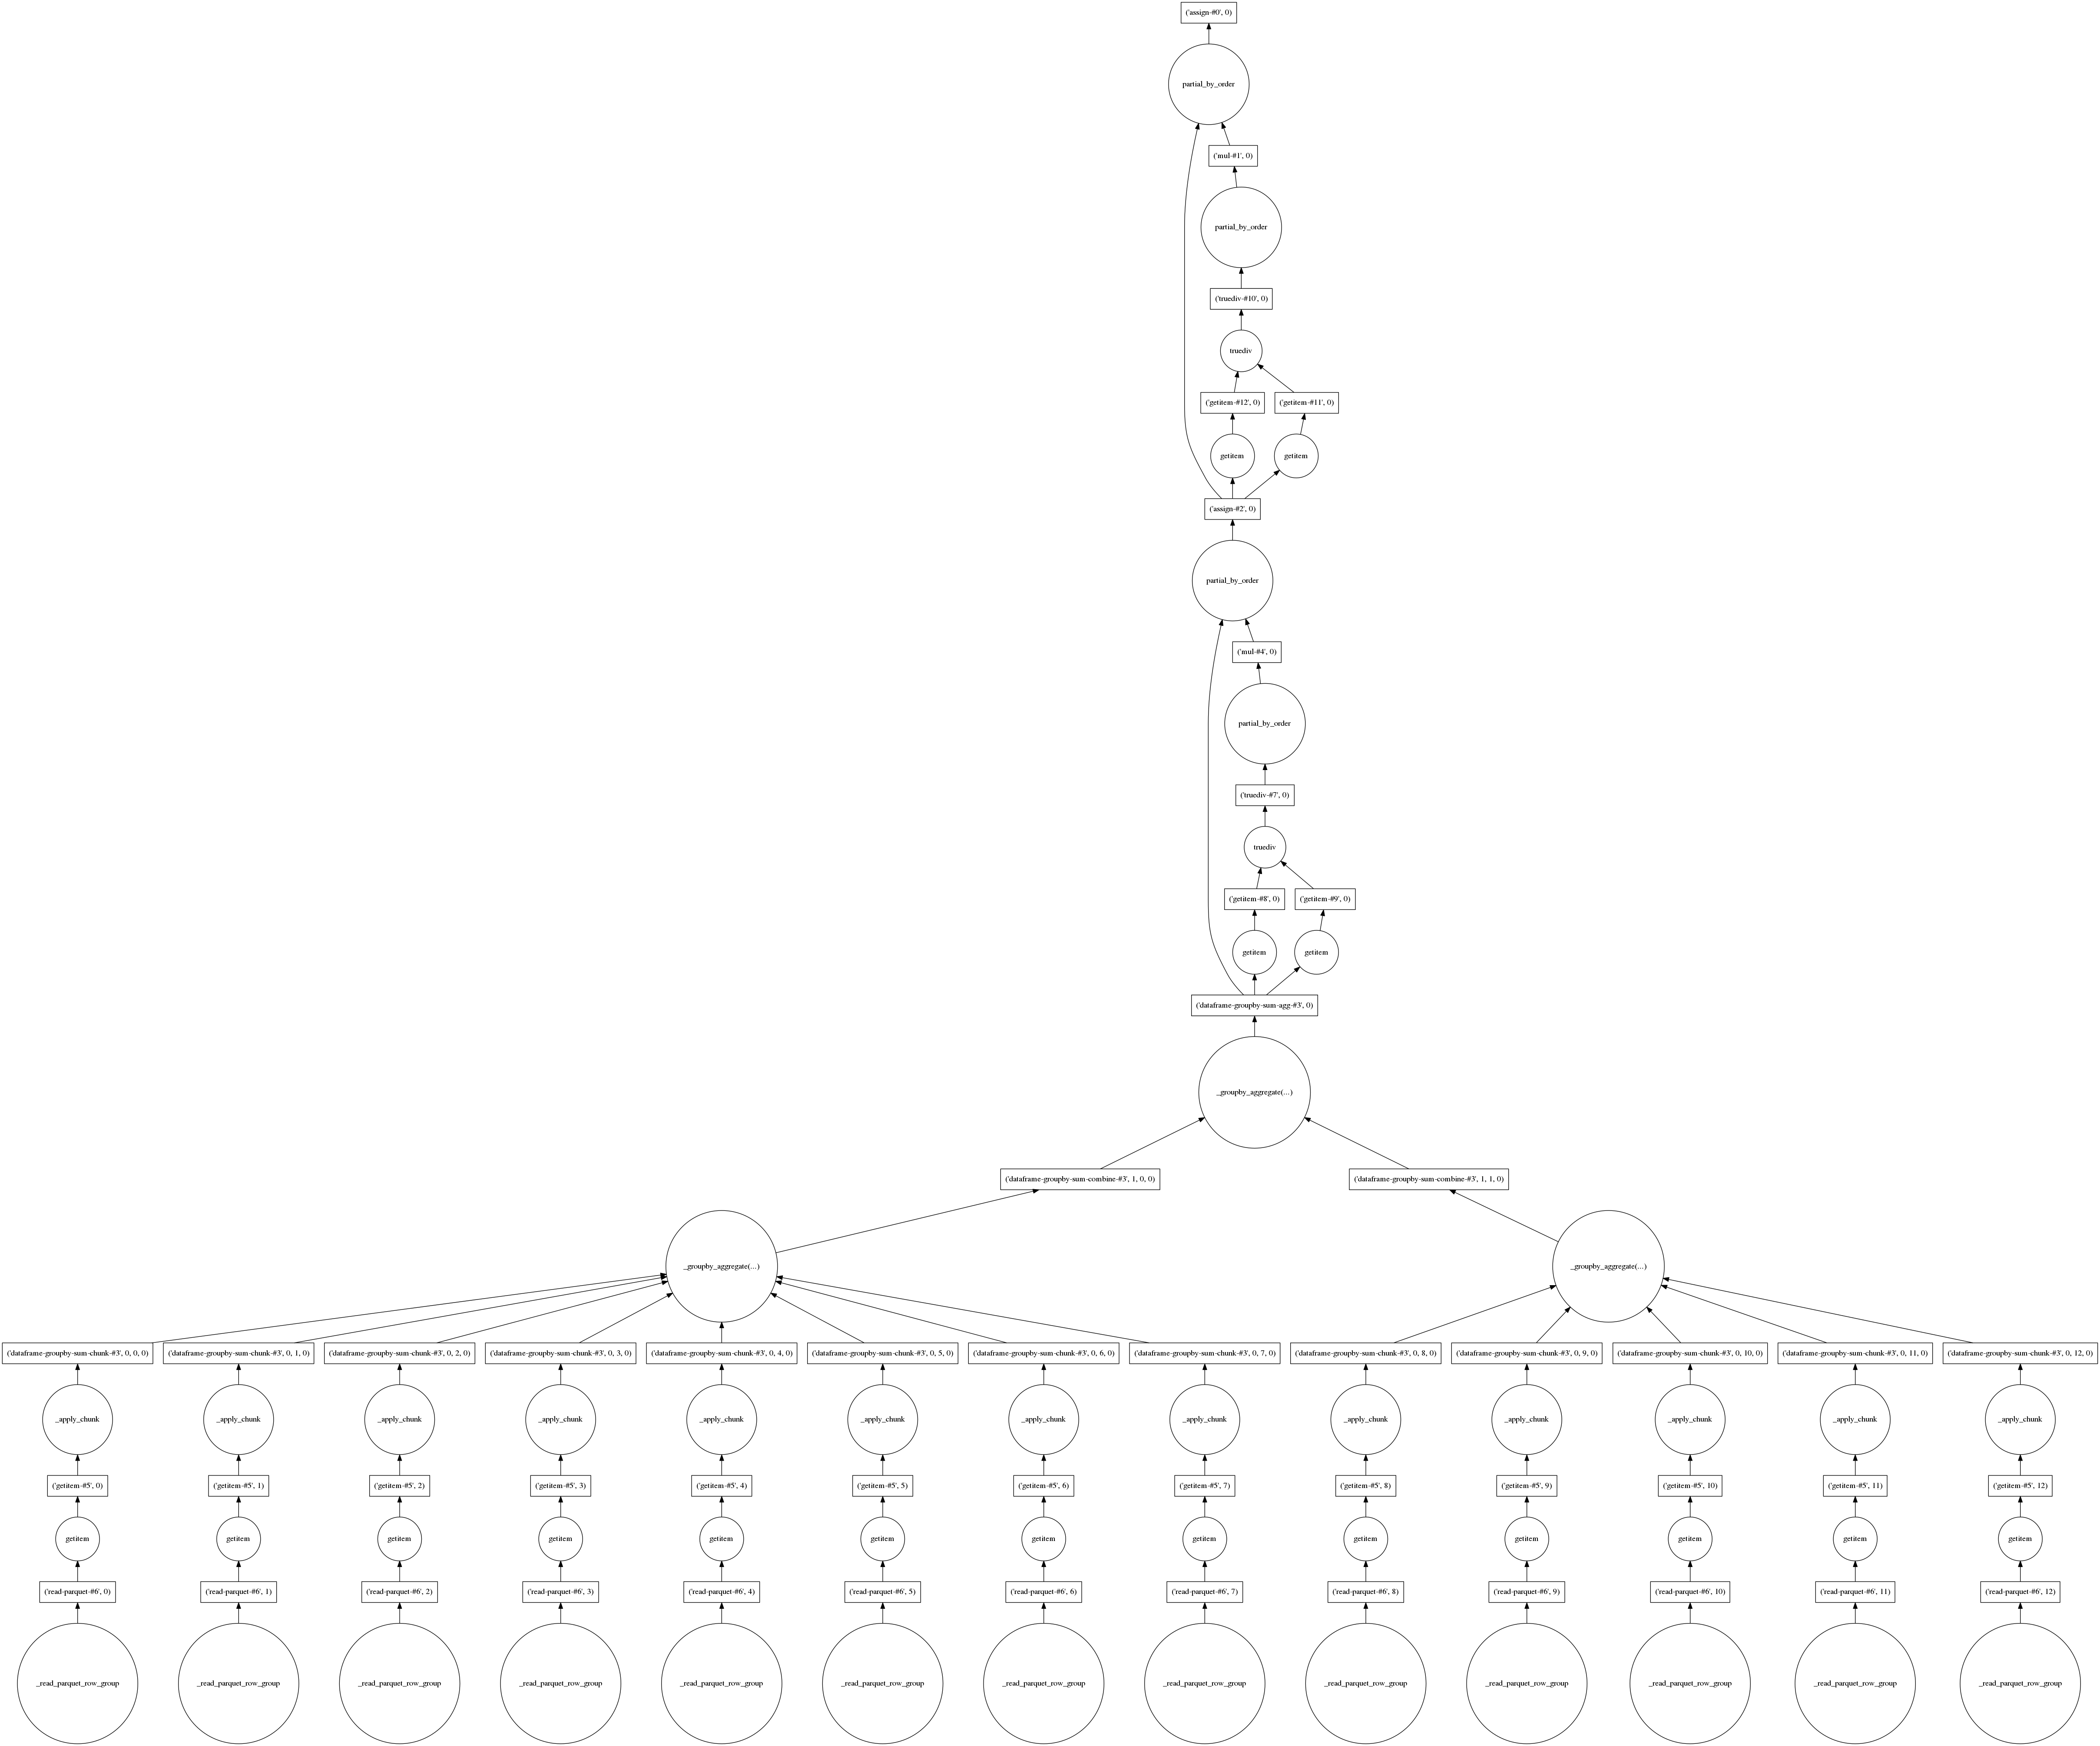

In [293]:
task.visualize()

In [269]:
import dask.diagnostics
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from cachey import nbytes

with ProgressBar():
    with Profiler() as prof, \
            ResourceProfiler(dt=0.25) as rprof, \
                CacheProfiler(metric=nbytes) as cprof:
        df = task.compute()
dask.diagnostics.visualize([prof, rprof, cprof], save=False, show=True)

[########################################] | 100% Completed |  2.4s


Column(id='1d81e98e-be89-4fad-abaa-1b20e11d1195', ...)

In [272]:
task

,Flights,Cancelled,Diverted,CancelledPct,DivertedPct
npartitions=1,,,,,
None,float64,float64,float64,float64,float64
None,...,...,...,...,...


In [273]:
task.describe()

,Flights,Cancelled,Diverted,CancelledPct,DivertedPct
npartitions=1,,,,,
None,float64,float64,float64,float64,float64
None,...,...,...,...,...


In [274]:
task._name

'assign-a30a129bc34ef62b6019faf6782c475c'

In [279]:
task._meta

,Flights,Cancelled,Diverted,CancelledPct,DivertedPct
Carrier,,,,,


In [276]:
from pprint import pprint

In [282]:
print('\n'.join(map(str,sorted(task.dask.keys()))))

('assign-a30a129bc34ef62b6019faf6782c475c', 0)
('assign-e2a3f51ed524497975f4b148995381ce', 0)
('dataframe-groupby-sum-agg-b65452308fa37f9d7c2918b0ae6daf88', 0)
('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 0, 0)
('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 1, 0)
('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 2, 0)
('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 3, 0)
('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 4, 0)
('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 5, 0)
('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 6, 0)
('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 7, 0)
('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 8, 0)
('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 9, 0)
('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 10, 0)
('dataframe-groupby-sum-c

In [283]:
task.dask[('mul-0437b7b743e7c3e1b3c755647213950d', 0)]

(<function dask.compatibility.apply>,
 <function dask.array.core.partial_by_order>,
 [('truediv-9b14876e68936854bfa0a269d46b61cf', 0)],
 {'function': <function _operator.mul>, 'other': [(1, 100)]})

In [285]:
task.dask[('dataframe-groupby-sum-combine-b65452308fa37f9d7c2918b0ae6daf88', 1, 0, 0)]

(<function dask.compatibility.apply>,
 <function dask.dataframe.groupby._groupby_aggregate>,
 [(<function dask.dataframe.core._concat>,
   [('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 0, 0),
    ('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 1, 0),
    ('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 2, 0),
    ('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 3, 0),
    ('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 4, 0),
    ('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 5, 0),
    ('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88', 0, 6, 0),
    ('dataframe-groupby-sum-chunk-b65452308fa37f9d7c2918b0ae6daf88',
     0,
     7,
     0)])],
 {'aggfunc': <methodcaller: sum>, 'levels': 0})

In [286]:
ddf.Carrier.dask

{('getitem-1244c6d90264ef148db32733d851ffc7',
  0): (<function _operator.getitem>, ('read-parquet-c251c74ec4dcd5ceee2c805ffa3f86db',
   0), 'Carrier'),
 ('getitem-1244c6d90264ef148db32733d851ffc7',
  1): (<function _operator.getitem>, ('read-parquet-c251c74ec4dcd5ceee2c805ffa3f86db',
   1), 'Carrier'),
 ('getitem-1244c6d90264ef148db32733d851ffc7',
  2): (<function _operator.getitem>, ('read-parquet-c251c74ec4dcd5ceee2c805ffa3f86db',
   2), 'Carrier'),
 ('getitem-1244c6d90264ef148db32733d851ffc7',
  3): (<function _operator.getitem>, ('read-parquet-c251c74ec4dcd5ceee2c805ffa3f86db',
   3), 'Carrier'),
 ('getitem-1244c6d90264ef148db32733d851ffc7',
  4): (<function _operator.getitem>, ('read-parquet-c251c74ec4dcd5ceee2c805ffa3f86db',
   4), 'Carrier'),
 ('getitem-1244c6d90264ef148db32733d851ffc7',
  5): (<function _operator.getitem>, ('read-parquet-c251c74ec4dcd5ceee2c805ffa3f86db',
   5), 'Carrier'),
 ('getitem-1244c6d90264ef148db32733d851ffc7',
  6): (<function _operator.getitem>, ('rea